# **Previsão de Vendas Futuras para Otimização de Estoque e Logística**

O **Walmart**, como grande varejista, precisa **prever suas vendas futuras** para otimizar o estoque, reduzir custos de armazenamento e evitar a falta de produtos.

A previsão de vendas ajuda na tomada de decisões estratégicas relacionadas a compras, marketing e operações logísticas.

Uma previsão precisa permite uma melhor gestão do inventário, minimizando o risco de excesso ou falta de produtos, além de otimizar os recursos financeiros e operacionais.



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from num2words import num2words
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error



In [ ]:
pip install num2words

> Função para Carregar e preparar dados

In [ ]:
def carregar_e_preparar_dados(caminho_arquivo):
    data = pd.read_csv(caminho_arquivo)
    data = data.rename(columns={
        'Unnamed: 0': 'indice',
        'Store': 'loja',
        'Dept': 'departamento',
        'Date': 'date',
        'Weekly_Sales': 'vendas_semanais',
        'IsHoliday': 'feriado',
        'Temperature': 'temperatura',
        'Fuel_Price': 'preco_combustivel',
        'MarkDown1': 'desconto1',
        'MarkDown2': 'desconto2',
        'MarkDown3': 'desconto3',
        'MarkDown4': 'desconto4',
        'MarkDown5': 'desconto5',
        'CPI': 'cpi',
        'Population': 'populacao',
        'Unemployment': 'desemprego',
        'Type': 'tipo',
        'Size': 'tamanho',
        'Super_Bowl': 'super_bowl',
        'Labor_Day': 'dia_do_trabalho',
        'Thanksgiving': 'acao_de_gracas',
        'Christmas': 'natal',
        'week': 'week',
        'month': 'month',
        'year': 'year'
    })
    data.dropna(inplace=True)
    data['vendas_em_mil'] = (data['vendas_semanais'] / 1000).round()
    return data

In [ ]:
data.head()

,indice,loja,departamento,date,vendas_semanais,feriado,temperatura,preco_combustivel,desconto1,desconto2,...,tipo,tamanho,super_bowl,dia_do_trabalho,acao_de_gracas,natal,week,month,year,vendas_em_mil
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,...,A,151315.0,False,False,False,False,5.0,2.0,2010.0,25.0
1,1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,...,A,151315.0,False,False,False,False,5.0,2.0,2010.0,51.0
2,2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,...,A,151315.0,False,False,False,False,5.0,2.0,2010.0,14.0
3,3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,...,A,151315.0,False,False,False,False,5.0,2.0,2010.0,40.0
4,4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,...,A,151315.0,False,False,False,False,5.0,2.0,2010.0,32.0


In [ ]:
event_columns = ['feriado', 'super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal']
data[event_columns] = data[event_columns].replace({True: 1, False: 0})
data.head()


,indice,loja,departamento,date,vendas_semanais,feriado,temperatura,preco_combustivel,desconto1,desconto2,...,tamanho,super_bowl,dia_do_trabalho,acao_de_gracas,natal,week,month,year,vendas_em_mil,evento
0,0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,25.0,Não Evento
1,1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,51.0,Não Evento
2,2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,14.0,Não Evento
3,3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,40.0,Não Evento
4,4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,32.0,Não Evento


> Função para agrupar e visualizar vendas

In [ ]:
def visualizar_vendas_mensais(data):
    grouped_data = data.groupby(['year', 'month'])['vendas_em_mil'].sum().reset_index()
    grouped_data['date'] = pd.to_datetime(grouped_data[['year', 'month']].assign(day=1))

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='date', y='vendas_em_mil', data=grouped_data, marker='o')
    plt.title('Vendas Mensais ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Vendas Mensais (mil)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    heatmap_data = grouped_data.pivot(index='year', columns='month', values='vendas_em_mil')
    plt.figure(figsize=(12, 8))
    grafico = sns.heatmap(data=heatmap_data, cmap="coolwarm", annot=True, fmt=".0f")
    grafico.set(title="Vendas Mensais ao longo do tempo", xlabel='Mês', ylabel="Ano")
    plt.show()

> Função para Visualizar correlação entre vendas e temperatura

In [ ]:
def visualizar_correlacao_vendas_temperatura(data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='temperatura', x='vendas_semanais', data=data, palette='viridis')
    plt.title('Correlação Entre Vendas e Temperatura')
    plt.ylabel('Temperatura')
    plt.xlabel('Vendas Semanais')
    plt.grid(True)
    plt.show()

> Função para criar coluna de evento e calcular vendas médias

In [ ]:
def criar_coluna_evento_e_calcular_vendas(data):
    data['evento'] = data[['super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal']].apply(lambda x: 'Evento' if x.any() else 'Não Evento', axis=1)
    vendas_agrupadas = data.groupby('evento')['vendas_semanais'].mean().reset_index()
    return vendas_agrupadas

> Função para visualizar comparação de vendas em dias de evento

In [ ]:
def visualizar_comparacao_vendas_evento(vendas_agrupadas):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='evento', y='vendas_semanais', data=vendas_agrupadas, palette='viridis')
    plt.title('Comparação de Vendas em Dias de Evento vs. Outros Dias')
    plt.xlabel('Tipo de Dia')
    plt.ylabel('Vendas Médias Semanais')
    plt.grid(axis='y')
    plt.show()

> Executar o fluxo de trabalho

<ipython-input-190-7b414f7cfd57>:2: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(caminho_arquivo)


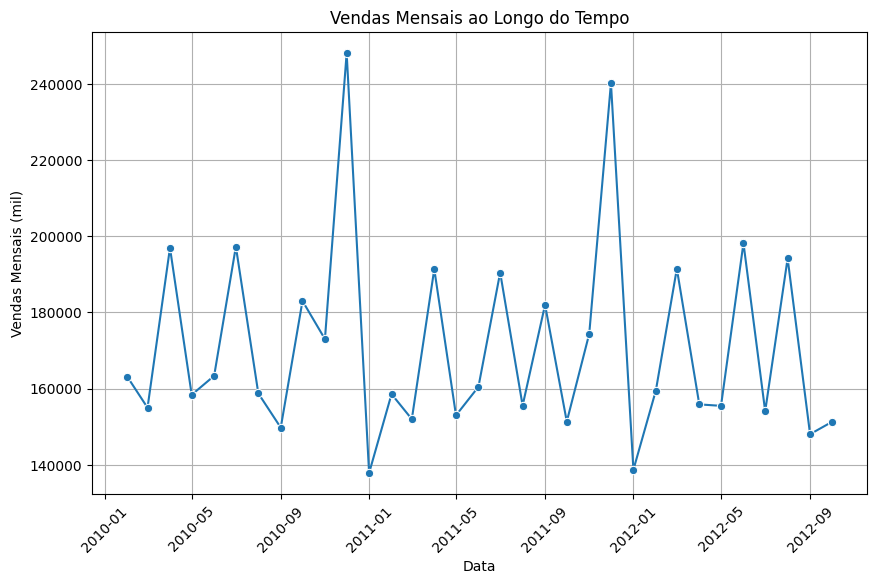

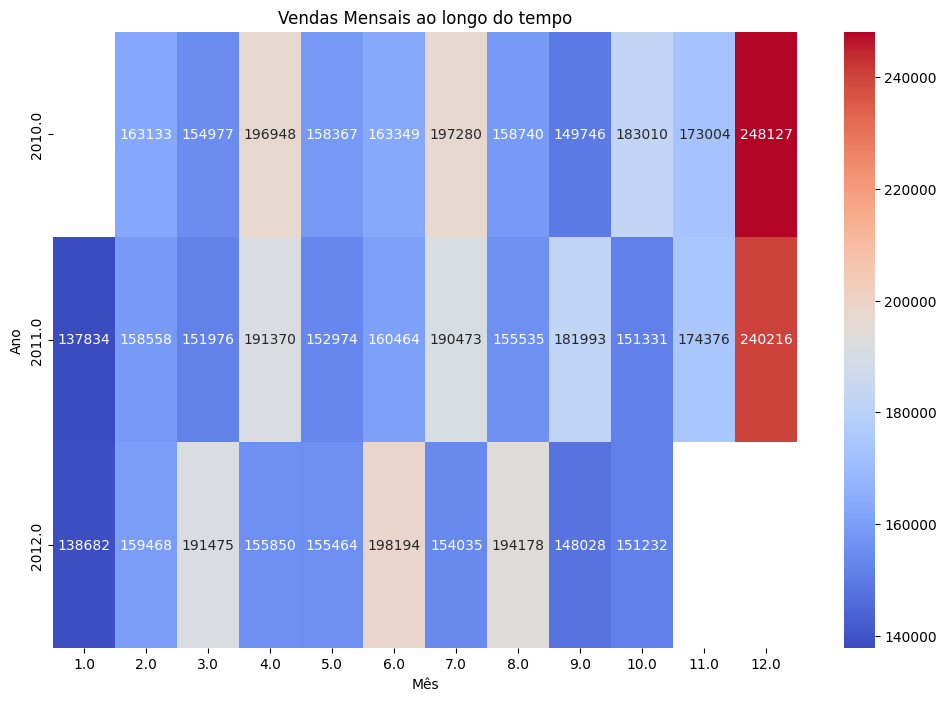

<ipython-input-193-de5f44e08c12>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y='temperatura', x='vendas_semanais', data=data, palette='viridis')


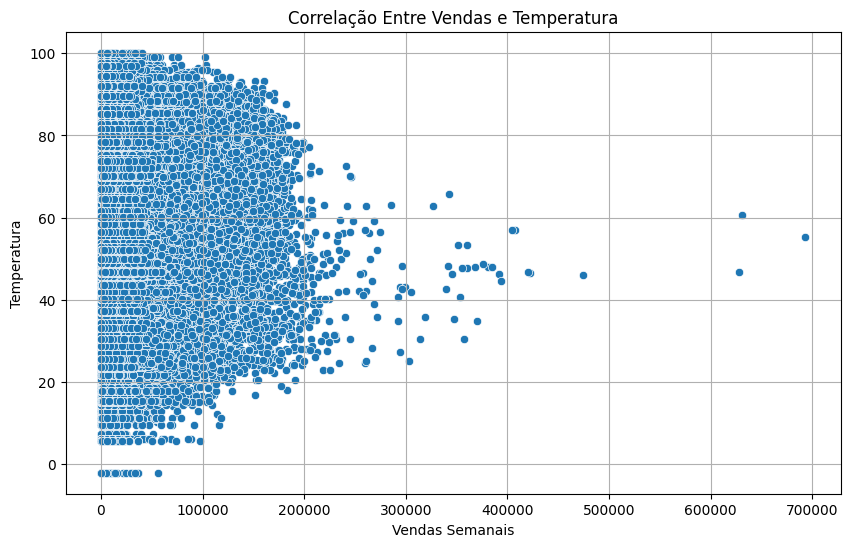

<ipython-input-195-58fb1f8a47ac>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='evento', y='vendas_semanais', data=vendas_agrupadas, palette='viridis')


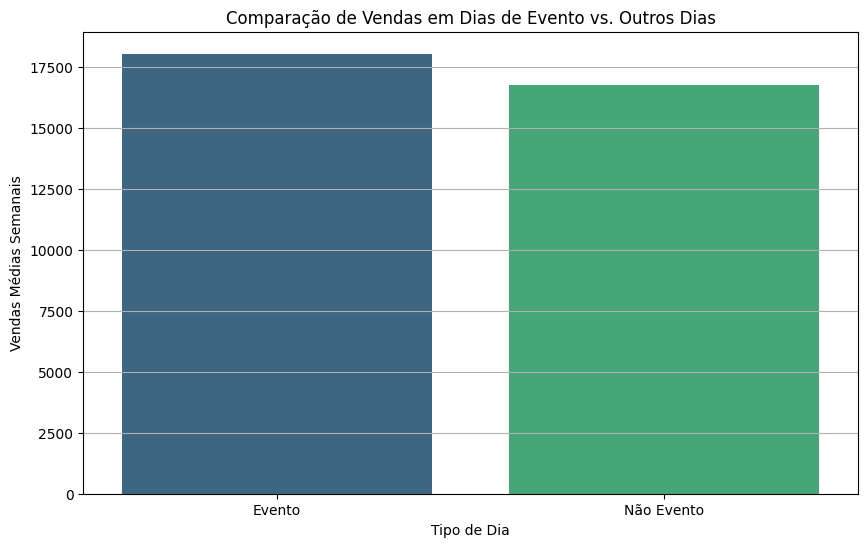

In [ ]:
if __name__ == "__main__":

    caminho_arquivo = 'clean_data.csv'
    data = carregar_e_preparar_dados(caminho_arquivo)

    visualizar_vendas_mensais(data)

    visualizar_correlacao_vendas_temperatura(data)

    vendas_agrupadas = criar_coluna_evento_e_calcular_vendas(data)

    visualizar_comparacao_vendas_evento(vendas_agrupadas)

    dados_agrupados = dados_modelo_encoded.groupby(['year', 'month'])['vendas_em_mil'].agg(['sum', 'mean']).reset_index()
    dados_agrupados.rename(columns={'sum': 'vendas_totais_mil', 'mean': 'vendas_media_mil'}, inplace=True)


# Vendas em Dias de Eventos:

As vendas são significativamente maiores em dias de eventos comparados a dias sem eventos. Isso sugere que eventos como feriados e datas comemorativas têm um impacto positivo nas vendas.

# Vendas e Temperatura:

Observamos que as vendas tendem a atingir valores mais elevados quando a temperatura está na faixa de 40°F a 60°F. Isso pode indicar que os consumidores estão mais propensos a fazer compras durante climas moderados, possivelmente devido ao conforto e a possibilidade de sair de casa para fazer compras.

# Dezembro:

A análise dos gráficos de linhas e do mapa de calor destaca uma variação notável nas vendas durante o mês de dezembro. Esse aumento pode estar associado às festas de fim de ano, como o Natal, que geralmente traz um aumento significativo nas compras devido a presentes e celebrações. Essa sazonalidade deve ser considerada ao planejar estoque e promoções para maximizar as vendas durante este período.

# Regressão para prever vendas com base em variáveis preditoras como datas de feriado e temperatura

> Prever vendas para os feriados: Ação de Graças, Super Bowl, Dia do Trabalho e Natal

In [ ]:
data.head(100)

,indice,loja,departamento,date,vendas_semanais,feriado,temperatura,preco_combustivel,desconto1,desconto2,...,tamanho,super_bowl,dia_do_trabalho,acao_de_gracas,natal,week,month,year,vendas_em_mil,evento
0,0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,25.0,Não Evento
1,1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,51.0,Não Evento
2,2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,14.0,Não Evento
3,3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,40.0,Não Evento
4,4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,...,151315.0,0,0,0,0,5.0,2.0,2010.0,32.0,Não Evento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,1,24,2010-02-12,8050.24,1,38.51,2.548,0.0,0.0,...,151315.0,1,0,0,0,6.0,2.0,2010.0,8.0,Evento
96,96,1,25,2010-02-12,13268.75,1,38.51,2.548,0.0,0.0,...,151315.0,1,0,0,0,6.0,2.0,2010.0,13.0,Evento
97,97,1,26,2010-02-12,10050.92,1,38.51,2.548,0.0,0.0,...,151315.0,1,0,0,0,6.0,2.0,2010.0,10.0,Evento
98,98,1,27,2010-02-12,2339.50,1,38.51,2.548,0.0,0.0,...,151315.0,1,0,0,0,6.0,2.0,2010.0,2.0,Evento


In [ ]:
caminho_arquivo = 'clean_data.csv'
data = carregar_e_preparar_dados(caminho_arquivo)
colunas_para_manter = ['temperatura', 'super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal', 'month', 'year', 'vendas_em_mil']
data_reduzida = data[colunas_para_manter]
dados_agrupados = data_reduzida.groupby(['year', 'month']).agg({
    'temperatura': 'mean',
    'vendas_em_mil': 'sum',
    'super_bowl': 'max',
    'dia_do_trabalho': 'max',
    'acao_de_gracas': 'max',
    'natal': 'max'
}).reset_index()

dados_agrupados.head()

<ipython-input-190-7b414f7cfd57>:2: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(caminho_arquivo)


,year,month,temperatura,vendas_em_mil,super_bowl,dia_do_trabalho,acao_de_gracas,natal
0,2010.0,2.0,34.808591,163133.0,True,False,False,False
1,2010.0,3.0,46.252550,154977.0,False,False,False,False
2,2010.0,4.0,56.119665,196948.0,False,False,False,False
3,2010.0,5.0,64.580028,158367.0,False,False,False,False
4,2010.0,6.0,74.299745,163349.0,False,False,False,False


In [ ]:
event_columns = ['super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal']
dados_agrupados[event_columns] = dados_agrupados[event_columns].replace({True: 1, False: 0})
dados_agrupados.head()

,year,month,temperatura,vendas_em_mil,super_bowl,dia_do_trabalho,acao_de_gracas,natal
0,2010.0,2.0,34.808591,163133.0,1,0,0,0
1,2010.0,3.0,46.252550,154977.0,0,0,0,0
2,2010.0,4.0,56.119665,196948.0,0,0,0,0
3,2010.0,5.0,64.580028,158367.0,0,0,0,0
4,2010.0,6.0,74.299745,163349.0,0,0,0,0


> Treino / Teste

In [ ]:
predictors = dados_agrupados[['super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal', 'year', 'month', 'temperatura']]
target = dados_agrupados['vendas_em_mil']

predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors,
    target,
    test_size=0.25,
    random_state=123
)

model = LinearRegression()
model.fit(predictors_train, target_train)

a = model.coef_
print(a)

b = model.intercept_
print(b)

[  -828.53580598   4226.70342196  39073.08364559 120737.04333776
   1449.49548694  -3815.47161004    757.86124548]
-2774544.8102230504


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Predições de vendas: Dezembro, Super Bowl, Dia do Trabalaho, Ação de Graças e Natal

In [ ]:
def prever_vendas(evento, valor_evento, year=2010, month=1, temperatura=20):
    evento_df = pd.DataFrame({
        'super_bowl': [0],
        'dia_do_trabalho': [0],
        'acao_de_gracas': [0],
        'natal': [0],
        'year': [year],
        'month': [month],
        'temperatura': [temperatura]
    })
    evento_df.loc[0, evento] = valor_evento
    colunas_necessarias = ['super_bowl', 'dia_do_trabalho', 'acao_de_gracas', 'natal', 'year', 'month', 'temperatura']
    for coluna in colunas_necessarias:
        if coluna not in evento_df.columns:
            evento_df[coluna] = 0

    vendas_esperadas = model.predict(evento_df)
    vendas_esperadas_mil = vendas_esperadas[0] * 1000
    vendas_esperadas_mil_rounded = round(vendas_esperadas_mil, -6)
    vendas_extenso = num2words(vendas_esperadas_mil_rounded, lang='pt_BR').split("vírgula")[0]
    print(f"Para o {evento}, espera-se um valor de R$ {vendas_esperadas_mil:.2f} em vendas!")
    print(f"Aproximadamente {vendas_extenso}.\n")


prever_vendas("super_bowl", 1)
prever_vendas("dia_do_trabalho", 1)
prever_vendas("acao_de_gracas", 1)
prever_vendas("natal", 1)

Para o super_bowl, espera-se um valor de R$ 149454336.03 em vendas!
Aproximadamente cento e quarenta e nove milhões.

Para o dia_do_trabalho, espera-se um valor de R$ 154509575.26 em vendas!
Aproximadamente cento e cinquenta e cinco milhões.

Para o acao_de_gracas, espera-se um valor de R$ 189355955.48 em vendas!
Aproximadamente cento e oitenta e nove milhões.

Para o natal, espera-se um valor de R$ 271019915.17 em vendas!
Aproximadamente duzentos e setenta e um milhões.



> Avaliação

In [ ]:
target_predicted=model.predict(predictors_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(target_test,target_predicted))
print(rmse)

22092.73092854128


> RSME: Um RSME de 22.000 é bastante baixo quando comparado com valores de vendas na faixa de R$ 271.019.915,17. Isso indica que O modelo tem um bom desempenho na previsão das vendas e é bastante preciso para os valores de vendas considerados.

# Visualização

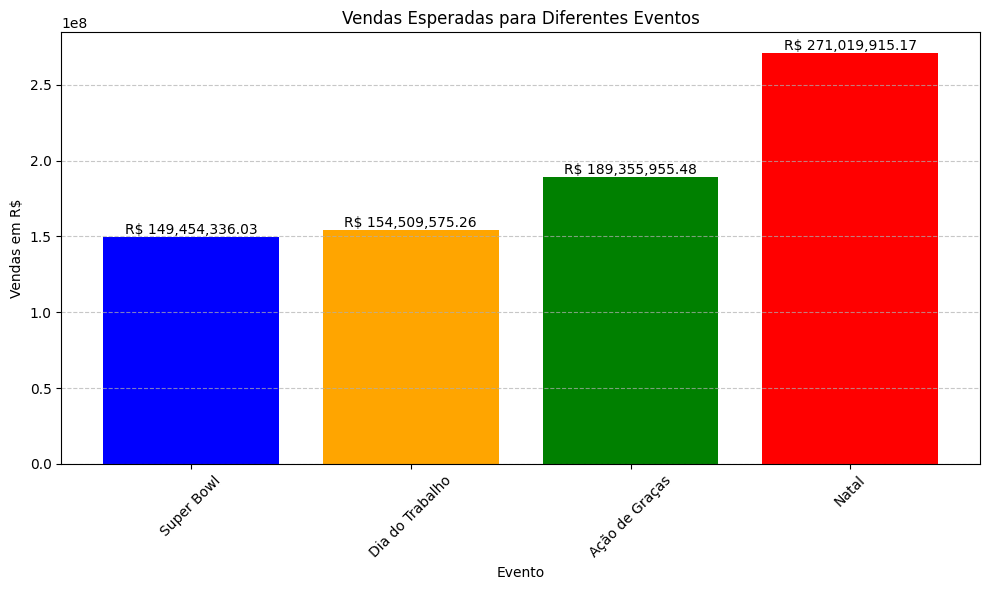

In [ ]:
eventos = ['Super Bowl', 'Dia do Trabalho', 'Ação de Graças', 'Natal']
vendas = [149454336.03, 154509575.26, 189355955.48, 271019915.17]
plt.figure(figsize=(10, 6))
bars = plt.bar(eventos, vendas, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Evento')
plt.ylabel('Vendas em R$')
plt.title('Vendas Esperadas para Diferentes Eventos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'R$ {height:,.2f}',
             ha='center', va='bottom', fontsize=10, color='black')
plt.tight_layout()
plt.show()
